In [1]:
from tifffile import imread
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from pathlib import Path
import napari
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = Path.home() / "Desktop/Code/CELLSEG_BENCHMARK/classifier_test/crops_128"
images_p = list(DATA_PATH.glob("*.tif"))
images_p.sort()
print(f"Loaded {len(images_p)} images")
images = [imread(str(image)) for image in images_p]

DATA_DF_PATH = DATA_PATH / "data_df.csv"

Loaded 64 images


In [3]:
if not DATA_DF_PATH.exists():
    data_df = pd.DataFrame([i.name[:-4] for i in images_p], columns=["image_path"])
    # add 100 bins of the hist of each image
    hists = []
    for i, image in enumerate(images):
        # remap to [0, 1000]
        im_normalized = (image - image.min()) / (image.max() - image.min()) * 1000
        # hists.append(np.histogram(im_normalized, bins=100)[0])
        hist = np.histogram(im_normalized, bins=100)[0]
        hist = hist / hist.sum()
        hists.append(hist)
        
    data_df = pd.concat([data_df, pd.DataFrame(hists)], axis=1)
else:
    data_df = pd.read_csv(DATA_DF_PATH)
    # make the hist a density
    # data_df.iloc[:, 1:-1] = data_df.iloc[:, 1:-1].div(data_df.iloc[:, 1:-1].sum(axis=1), axis=0)
    # make the hist a percentage
    data_df.iloc[:, 1:-1] = data_df.iloc[:, 1:-1] / data_df.iloc[:, 1:-1].sum(axis=1).values[:, None]
data_df.head()

,image_path,0,1,2,3,4,5,6,7,8,...,91,92,93,94,95,96,97,98,99,label
0,segmented_whole_volume_fragmented_0,4.768372e-07,0.000000e+00,0.000000e+00,0.000000,0.000000,4.768372e-07,4.768372e-07,1.907349e-06,2.384186e-06,...,0.000001,0.000000e+00,0.000001,4.768372e-07,4.768372e-07,0.000000e+00,4.768372e-07,0.000000e+00,4.768372e-07,1
1,segmented_whole_volume_fragmented_1,4.768372e-07,0.000000e+00,0.000000e+00,0.000000,0.000000,4.768372e-07,4.768372e-07,1.907349e-06,2.384186e-06,...,0.000001,0.000000e+00,0.000001,4.768372e-07,4.768372e-07,0.000000e+00,4.768372e-07,0.000000e+00,4.768372e-07,1
2,segmented_whole_volume_fragmented_10,9.536743e-07,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.768372e-07,...,0.000091,6.103516e-05,0.000036,2.336502e-05,1.716614e-05,6.198883e-06,1.430511e-06,1.907349e-06,2.384186e-06,0
3,segmented_whole_volume_fragmented_11,4.768372e-07,4.768372e-07,4.768372e-07,0.000000,0.000000,9.536743e-07,9.536743e-07,9.536743e-07,0.000000e+00,...,0.000213,1.630783e-04,0.000129,1.273155e-04,8.344650e-05,6.151199e-05,3.767014e-05,2.241135e-05,1.096725e-05,1
4,segmented_whole_volume_fragmented_12,9.536743e-07,0.000000e+00,1.430511e-06,0.000004,0.000006,7.152557e-06,1.144409e-05,1.764297e-05,2.574921e-05,...,0.000002,9.536743e-07,0.000002,1.907349e-06,9.536743e-07,9.536743e-07,0.000000e+00,4.768372e-07,1.430511e-06,0


In [4]:
from napari.settings import get_settings

settings = get_settings()
settings.application.ipy_interactive = False
# labels = []

# for i, im in enumerate(images):
#     viewer = napari.Viewer()
    
#     @viewer.bind_key("o")
#     def next_label(event):
#         labels.append(0)
#         print("Added label 0")
        
#     @viewer.bind_key("p")
#     def next_label(event):
#         labels.append(1)
#         print("Added label 1")
        
#     @viewer.bind_key("q")
#     def next_label(event):
#         if len(labels) != i+1:
#             print("You need to label the current image first!")
#             return
#         else:
#             viewer.close()
#     @viewer.bind_key("u")
#     def undo_label(event):
#         labels.pop()
#         print("Removed last label")
#         print(labels)
    
#     viewer.add_image(im)
#     napari.run()

In [5]:
# data_df["label"] = labels
# # save data_df as csv
# data_df.to_csv(DATA_PATH / "data_df.csv", index=False)
# data_df.head()

In [6]:
classifier = RandomForestClassifier()
classifier.fit(data_df.iloc[:, 1:-1].values, data_df["label"].values)

RandomForestClassifier()

In [7]:
# test performance on training data
classifier.score(data_df.iloc[:, 1:-1].values, data_df["label"].values)

1.0

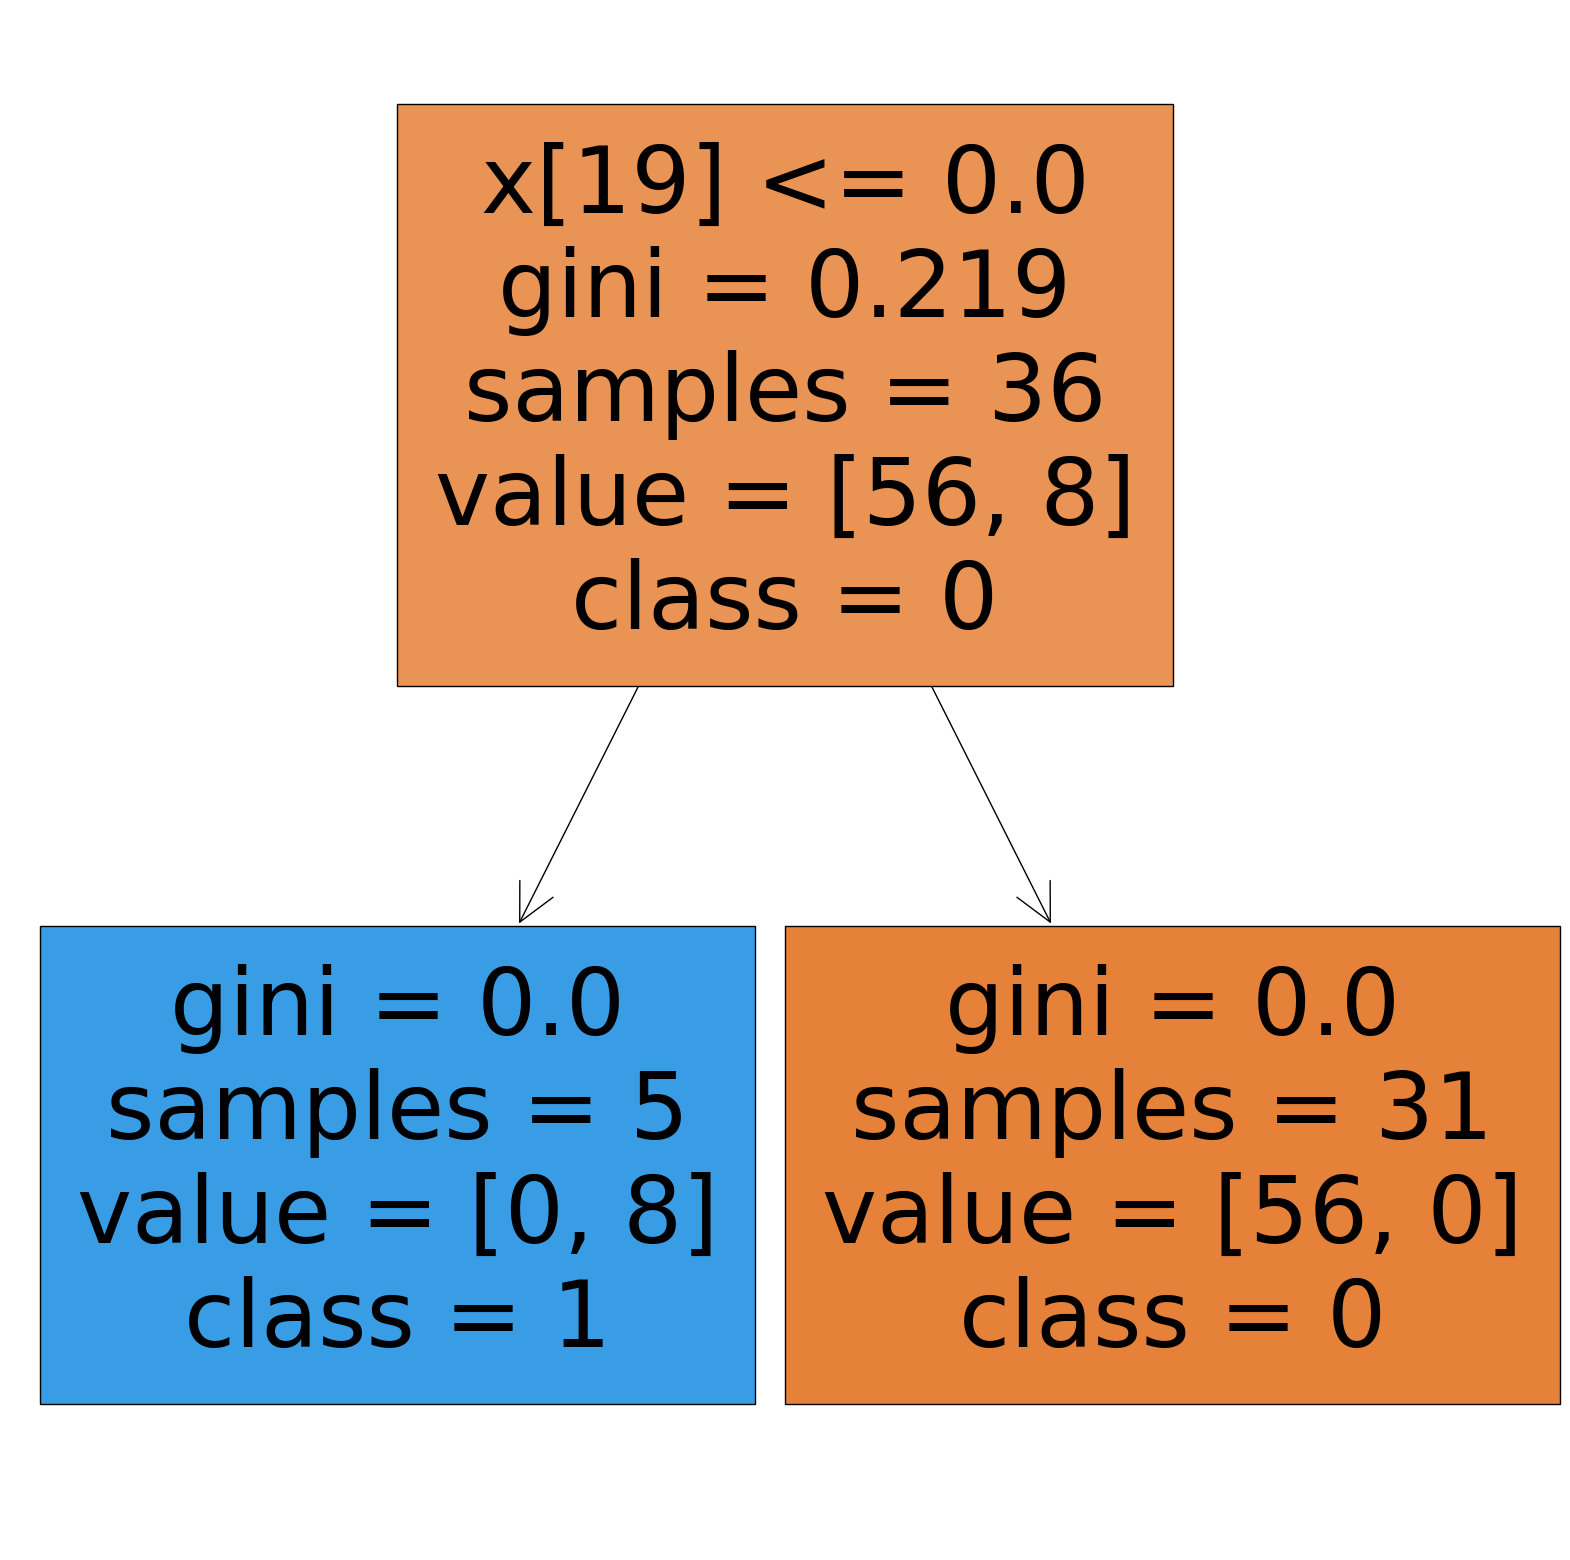

In [8]:
# plot decision tree
from sklearn import tree
plt.figure(figsize=(20, 20))
tree.plot_tree(classifier.estimators_[5], filled=True,class_names=["0", "1"])
plt.show()

In [9]:
# # plot all histograms
# fig, axs = plt.subplots(8, 8, figsize=(16, 16))
# for i, ax in enumerate(axs.flatten()):
#     ax.plot(data_df.iloc[i, 1:])
#     ax.set_yticklabels([])


In [10]:
TEST_CROPS_PATH = Path.home() / "Desktop/Code/CELLSEG_BENCHMARK/classifier_test/test_crops_128"
test_images_p = list(TEST_CROPS_PATH.glob("*.tif"))
test_images_p.sort()
print(f"Loaded {len(test_images_p)} images")

test_images = [imread(str(image)) for image in test_images_p]

for i, im in enumerate(test_images):
    norm_im = (im - im.min()) / (im.max() - im.min()) * 1000
    hist = np.histogram(norm_im, bins=100)[0]
    hist = hist / hist.sum()
    pred = classifier.predict(hist.reshape(1, -1))
    print(f"Image {i} is {pred}")
#     view = napari.view_image(im,colormap="turbo")
#     view.dims.ndisplay = 3
#     napari.run()

Loaded 128 images
Image 0 is [1]
Image 1 is [1]
Image 2 is [0]
Image 3 is [0]
Image 4 is [0]
Image 5 is [0]
Image 6 is [0]
Image 7 is [0]
Image 8 is [0]
Image 9 is [0]
Image 10 is [0]
Image 11 is [0]
Image 12 is [0]
Image 13 is [0]
Image 14 is [1]
Image 15 is [0]
Image 16 is [1]
Image 17 is [0]
Image 18 is [0]
Image 19 is [0]
Image 20 is [0]
Image 21 is [0]
Image 22 is [0]
Image 23 is [0]
Image 24 is [0]
Image 25 is [0]
Image 26 is [0]
Image 27 is [0]
Image 28 is [0]
Image 29 is [0]
Image 30 is [0]
Image 31 is [0]
Image 32 is [0]
Image 33 is [0]
Image 34 is [0]
Image 35 is [0]
Image 36 is [0]
Image 37 is [1]
Image 38 is [0]
Image 39 is [0]
Image 40 is [1]
Image 41 is [0]
Image 42 is [0]
Image 43 is [0]
Image 44 is [0]
Image 45 is [0]
Image 46 is [0]
Image 47 is [0]
Image 48 is [0]
Image 49 is [0]
Image 50 is [0]
Image 51 is [0]
Image 52 is [0]
Image 53 is [0]
Image 54 is [1]
Image 55 is [0]
Image 56 is [0]
Image 57 is [0]
Image 58 is [0]
Image 59 is [0]
Image 60 is [0]
Image 61 is [0]


In [14]:
TEST_CROPS_PATH = Path.home() / "Desktop/Code/CELLSEG_BENCHMARK/classifier_test/crops_64"
test_images_p = list(TEST_CROPS_PATH.glob("*.tif"))
test_images_p.sort()
print(f"Loaded {len(test_images_p)} images")

test_images = [imread(str(image)) for image in test_images_p]

for i, im in enumerate(test_images):
    norm_im = (im - im.min()) / (im.max() - im.min()) * 1000
    hist = np.histogram(norm_im, bins=100)[0]
    hist = hist / hist.sum()
    pred = classifier.predict(hist.reshape(1, -1))
    print(f"Image {i} is {pred}")
    view = napari.view_image(im,colormap="turbo")
    view.dims.ndisplay = 3
    napari.run()

Loaded 447 images
Image 0 is [0]
Image 1 is [0]
Image 2 is [1]
Image 3 is [0]
Image 4 is [0]
Image 5 is [0]
Image 6 is [0]
Image 7 is [0]
Image 8 is [0]
Image 9 is [0]
Image 10 is [0]
Image 11 is [0]
Image 12 is [0]
Image 13 is [0]


KeyboardInterrupt: 

Image 14 is [0]


In [11]:
TEST_DATA_PATH = Path.home() / "Desktop/Code/CELLSEG_BENCHMARK/classifier_test/test_preds_128.tif"
test_image = imread(str(TEST_DATA_PATH))

In [12]:
cube_size = 128
preds = np.zeros(test_image.shape)

for i in range(0, test_image.shape[0], cube_size):
    for j in range(0, test_image.shape[1], cube_size):
        for k in range(0, test_image.shape[2], cube_size):
            crop = test_image[i:i+cube_size, j:j+cube_size, k:k+cube_size]
            crop_normalized = (crop - crop.min()) / (crop.max() - crop.min()) * 1000
            hist = np.histogram(crop_normalized, bins=100)[0]
            hist = hist / hist.sum()
            pred = classifier.predict(hist.reshape(1, -1))[0]
            
            if pred == 0:
                preds[i:i+cube_size, j:j+cube_size, k:k+cube_size] = crop
            else:
                preds[i:i+cube_size, j:j+cube_size, k:k+cube_size] = 0

view = napari.view_image(preds, colormap="turbo")
view.add_image(test_image, colormap="turbo", blending="additive")
view.grid.enabled = True
view.dims.ndisplay = 3
napari.run()

In [ ]:
import joblib
joblib.dump(classifier, DATA_PATH / "classifier.joblib")